# Paris Housing

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

import warnings

In [168]:
df = pd.read_csv('data/ModifiedParisHousingClass.csv')

df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category,hasFullPack
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,Basic,0
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,Luxury,0
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,Basic,0
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,Basic,0
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,Luxury,0


## Classification

Let's start with the classification problem. The target variable that we are trying to predict is 'category'.

In [169]:
X = df.drop(columns=["category","hasFullPack"],axis=1)
#y = (df["category"] == 'Luxury').astype(int)
y = df["category"]

In [170]:
X.shape, y.shape

((10000, 17), (10000,))

### Scaling

In [171]:
num_features = X.select_dtypes(exclude=['object']).columns


num_transformer = StandardScaler()


#pipeline to encode the features

preprocessor = ColumnTransformer(
    [
        ("StandardScaler",num_transformer,num_features)
    ]
)

In [172]:
X = preprocessor.fit_transform(X)
X.shape

(10000, 17)

### Unbalanced problem

<Axes: xlabel='count', ylabel='category'>

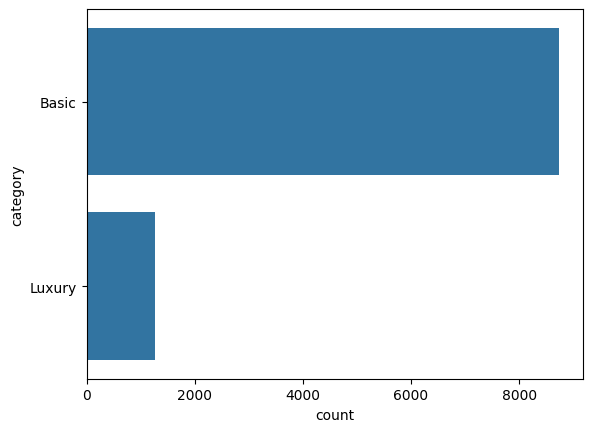

In [173]:
sns.countplot(df.category)

<Axes: xlabel='category', ylabel='count'>

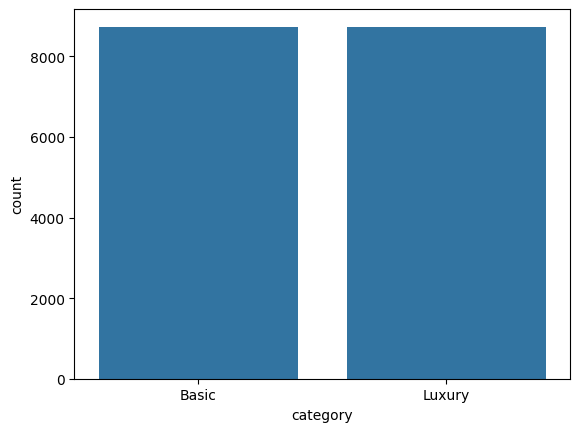

In [174]:
# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = ros.fit_resample(X, y)

sns.countplot(x=y_resampled)

### Train Test Split

In [175]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (13976, 17)
Shape of X_test: (3494, 17)


### Modelling

In [181]:
models = {
    "LogisticRegression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}
model_list = []
accuracy_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    acc_score = accuracy_score(y_test, y_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('----------------------------------')
        
    print('Accuracy Score of the model : {:.4f}'.format(acc_score) )
    print(confusion_matrix(y_test, y_pred))
    accuracy_list.append(acc_score)
    
    print('='*35)
    print('\n')

LogisticRegression
----------------------------------
Accuracy Score of the model : 1.0000
[[1793    0]
 [   0 1701]]




K-Neighbors Classifier
----------------------------------
Accuracy Score of the model : 0.9717
[[1694   99]
 [   0 1701]]


Decision Tree Classifier
----------------------------------
Accuracy Score of the model : 1.0000
[[1793    0]
 [   0 1701]]


Random Forest Classifier
----------------------------------
Accuracy Score of the model : 1.0000
[[1793    0]
 [   0 1701]]


CatBoosting Classifier
----------------------------------
Accuracy Score of the model : 1.0000
[[1793    0]
 [   0 1701]]


AdaBoost Classifier
----------------------------------
Accuracy Score of the model : 1.0000
[[1793    0]
 [   0 1701]]




## Regression

In [183]:
X = df.drop(columns=["price","hasFullPack"],axis=1)
y = df["price"]

### Encoding

In [188]:
num_features = X.select_dtypes(exclude=['object']).columns
cat_features = X.select_dtypes(include=['object']).columns

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

#pipeline to encode the features

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder",cat_transformer,cat_features),
        ("StandardScaler",num_transformer,num_features)
    ]
)

In [189]:
X = preprocessor.fit_transform(X)
X.shape

(10000, 18)

### Train Test Split

In [193]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (8000, 18)
Shape of X_test: (2000, 18)


### Evaluating function

In [194]:
def evaluate_model(true,predicted):
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true,predicted)
    r2=r2_score(true,predicted)
    rmse=np.sqrt(mse)
    
    return mae,rmse,r2

### Modelling

In [195]:
models = {
        "Linear Regression": LinearRegression(),
        "Lasso": Lasso(),
        "Ridge": Ridge(),
        "K-Neighbors Regressor": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest Regressor": RandomForestRegressor(),
        "XGBRegressor": XGBRegressor(), 
        "CatBoosting Regressor": CatBoostRegressor(verbose=False),
        "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
        
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1890.9175
- Mean Absolute Error: 1470.7674
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1922.1728
- Mean Absolute Error: 1509.9200
- R2 Score: 1.0000


Lasso
Model performance for Training set
- Root Mean Squared Error: 1891.0603
- Mean Absolute Error: 1471.0336
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1922.9068
- Mean Absolute Error: 1510.0208
- R2 Score: 1.0000


Ridge
Model performance for Training set
- Root Mean Squared Error: 1925.2946
- Mean Absolute Error: 1504.6287
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1957.2691
- Mean Absolute Error: 1543.1646
- R2 Score: 1.0000


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 1099629.8561
- Mean Absolute Error: 894440.

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 1448.7168
- Mean Absolute Error: 1152.1710
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4001.6768
- Mean Absolute Error: 3188.5844
- R2 Score: 1.0000


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 7636.9952
- Mean Absolute Error: 5972.4319
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 14079.7514
- Mean Absolute Error: 11573.0402
- R2 Score: 1.0000


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 14818.2199
- Mean Absolute Error: 11865.8676
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 18347.5341
- Mean Absolute Error: 14594.0522
- R2 Score: 1.0000


AdaBoost Regressor
Model performance for Training set
- Root Mean Squared Error: 350896.3255

In [196]:
results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
results

,Model Name,R2_Score
0,Linear Regression,1.000000
1,Lasso,1.000000
2,Ridge,1.000000
5,Random Forest Regressor,0.999998
4,Decision Tree,0.999996
6,XGBRegressor,0.999977
7,CatBoosting Regressor,0.999962
8,AdaBoost Regressor,0.985961
3,K-Neighbors Regressor,0.785266
